# Let's compare the models

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import matplotlib.pyplot as plt
from IPython.display import Image, display

from sklearn.model_selection import train_test_split
tfk.mixed_precision.set_global_policy("mixed_float16")

tf.random.set_seed(42)

print("Tensorflow version: ", tf.__version__)
print("Keras version: ", tfk.__version__)
print("Is GPU detected: ", len(tf.config.list_physical_devices('GPU'))>0)

Tensorflow version:  2.17.1
Keras version:  3.5.0
Is GPU detected:  False


## Load dataset

In [2]:
data = np.load('/kaggle/input/lung-cancer/lung_dataset_interpolated.npz')
full_slices = data['full_slices']
nodules = data['nodules']
tumor_classes = data['tumor_classes']

# Normalize images
# full_slices = full_slices / 255.0
# nodules = nodules / 255.0

print("tumor_classes shape: ", tumor_classes.shape)
print("nodules shape: ", nodules.shape)
print("tumor_classes shape: ", tumor_classes.shape)

tumor_classes shape:  (2363,)
nodules shape:  (2363, 138, 138)
tumor_classes shape:  (2363,)


In [3]:
import matplotlib.pyplot as plt

def plot_image(full_slice, nodule):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

    ax1.imshow(full_slice, cmap='gray')
    ax2.imshow(nodule, cmap='gray')

    plt.show()
    return

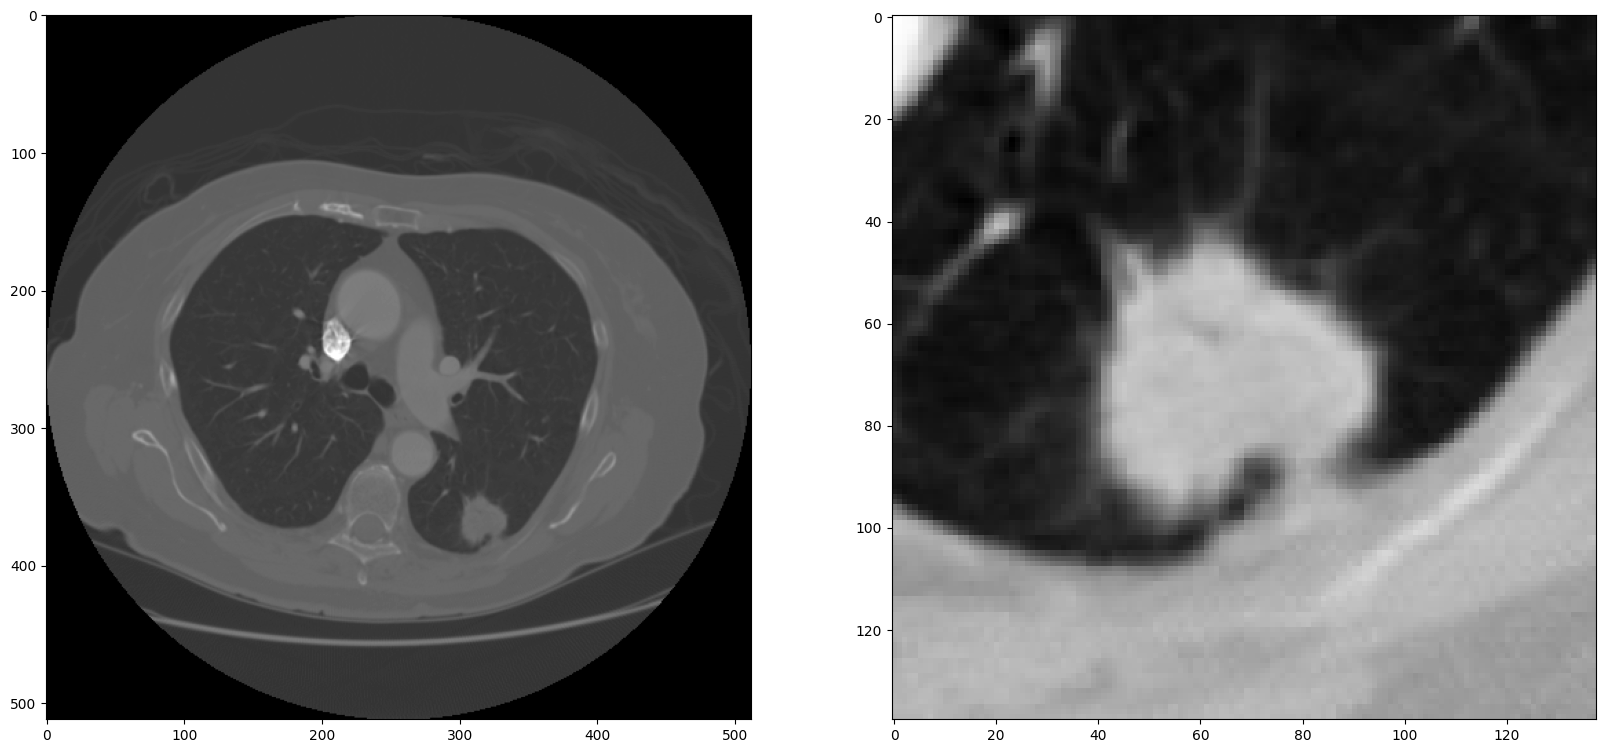

In [4]:
plot_image(full_slices[0], nodules[0])

### Preprocess data

In [5]:
import cv2 as cv
import numpy as np

def normalize(x):
    return (x - np.min(x)) / (np.max(x) -  np.min(x))

clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
kernel = np.ones((3, 3), np.uint8)

def img_enhancer(img):
    img = cv.medianBlur(img, 3)
    img = cv.equalizeHist(img)
    img = clahe.apply(img)
    img = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)
    img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    return img

def img_enhancer_logger(img):
    def plot_image(image, title='Image'):
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(title)
        plt.axis('off')
        plt.show()

    plot_image(img)
    img = cv.medianBlur(img, 3)
    plot_image(img)
    img = cv.equalizeHist(img)
    plot_image(img)
    img = clahe.apply(img)
    plot_image(img)
    img = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)
    plot_image(img)
    img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    plot_image(img)

In [6]:
from tqdm import tqdm

processed_full_slices = []

for img in tqdm(full_slices, desc="Processing full slices"):
    img = img_enhancer(np.ceil(normalize(img) * 255).astype("uint8"))
    processed_full_slices.append(cv.cvtColor(img, cv.COLOR_BGR2GRAY))

full_slices = np.array(processed_full_slices)

Processing full slices:  14%|█▍        | 333/2363 [00:01<00:10, 202.24it/s]<ipython-input-5-8aef7bf94be2>:5: RuntimeWarning: overflow encountered in scalar subtract
  return (x - np.min(x)) / (np.max(x) -  np.min(x))
Processing full slices: 100%|██████████| 2363/2363 [00:12<00:00, 193.25it/s]


In [7]:
processed_nodules = []

for img in tqdm(nodules, desc="Processing nodules"):
    img = img_enhancer(np.ceil(normalize(img) * 255).astype("uint8"))
    processed_nodules.append(img)
    
nodules = processed_nodules

Processing nodules: 100%|██████████| 2363/2363 [00:01<00:00, 1411.44it/s]


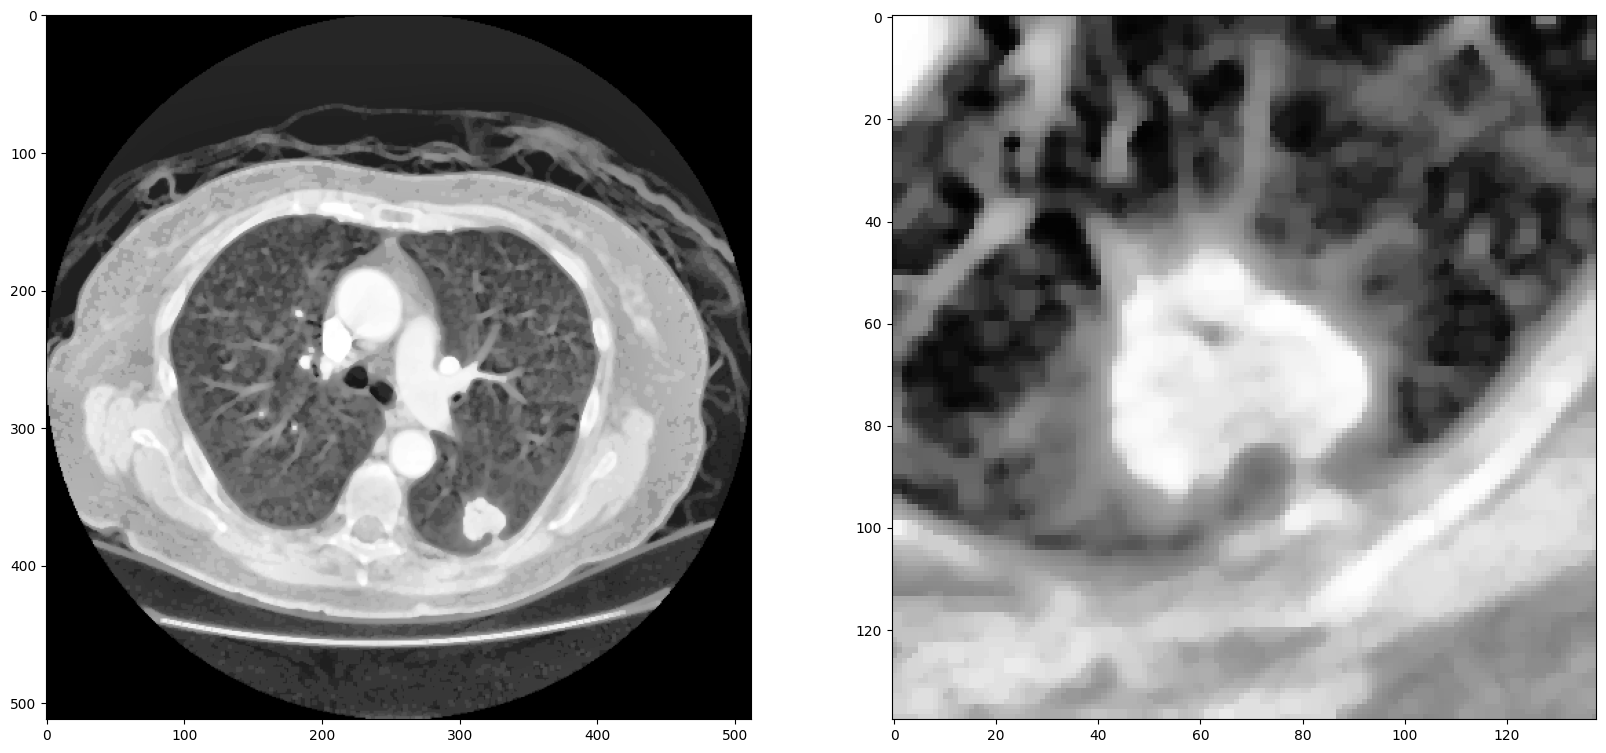

In [8]:
plot_image(full_slices[0], nodules[0])

In [9]:
def resize_nodule(img, target_size=(138, 138)):
    return cv.resize(img, target_size, interpolation=cv.INTER_AREA)

In [10]:
resized_nodules = [cv.cvtColor(resize_nodule(nodule), cv.COLOR_BGR2GRAY) for nodule in nodules]
nodules = np.array(resized_nodules)

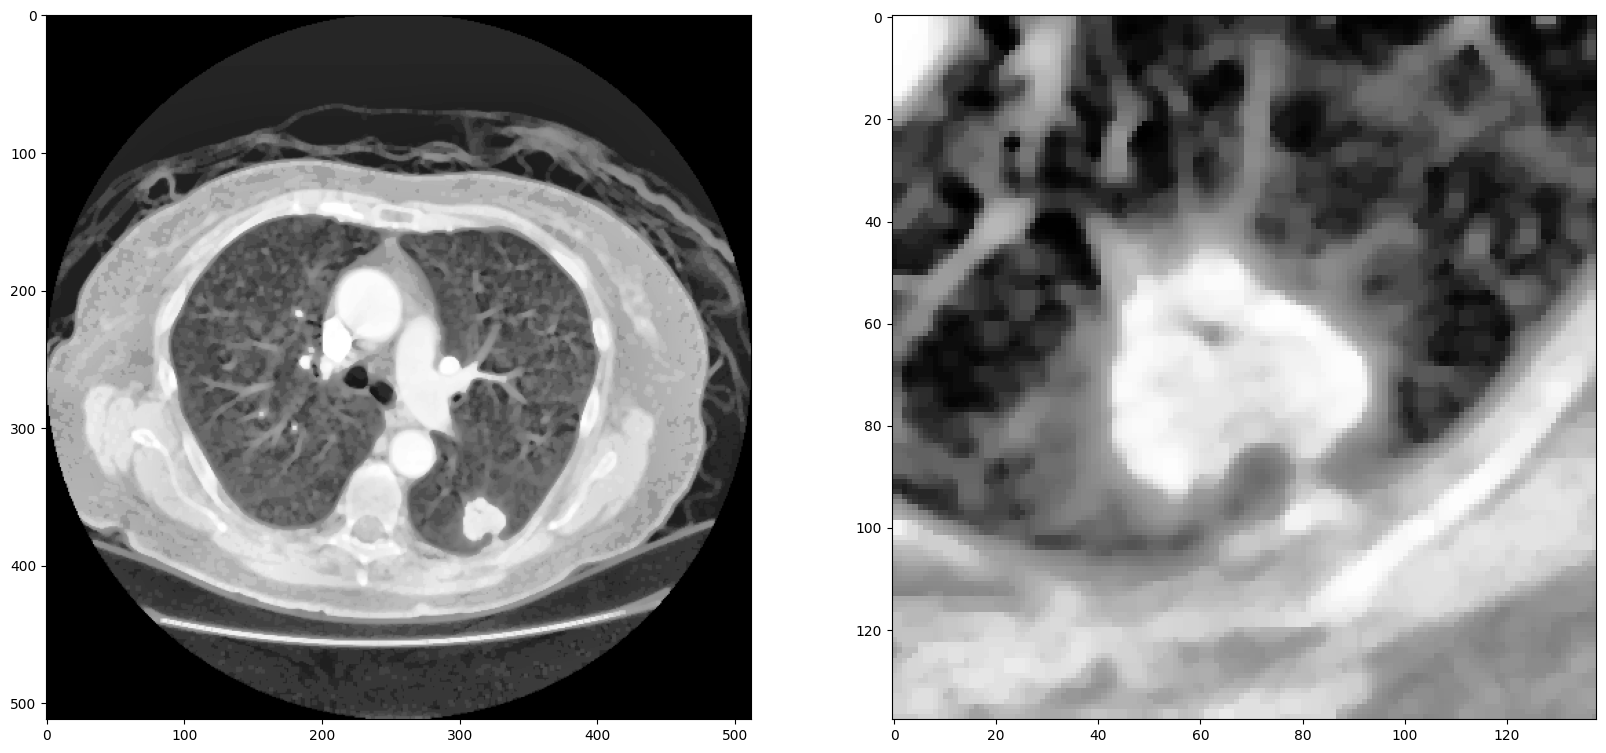

In [11]:
plot_image(full_slices[0], nodules[0])

In [12]:
full_slices.shape

(2363, 512, 512)

In [13]:
X = np.expand_dims(full_slices, -1)

In [14]:
X.shape

(2363, 512, 512, 1)

## Load model

In [15]:
grad_model = tfk.models.load_model("/kaggle/input/zeus-binary-full-slices/keras/default/1/CustomCNN_0.8116.keras")

## CAM Analysis

In [16]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tfk.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


def display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4):
    import matplotlib as mpl

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tfk.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tfk.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tfk.utils.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    return superimposed_img

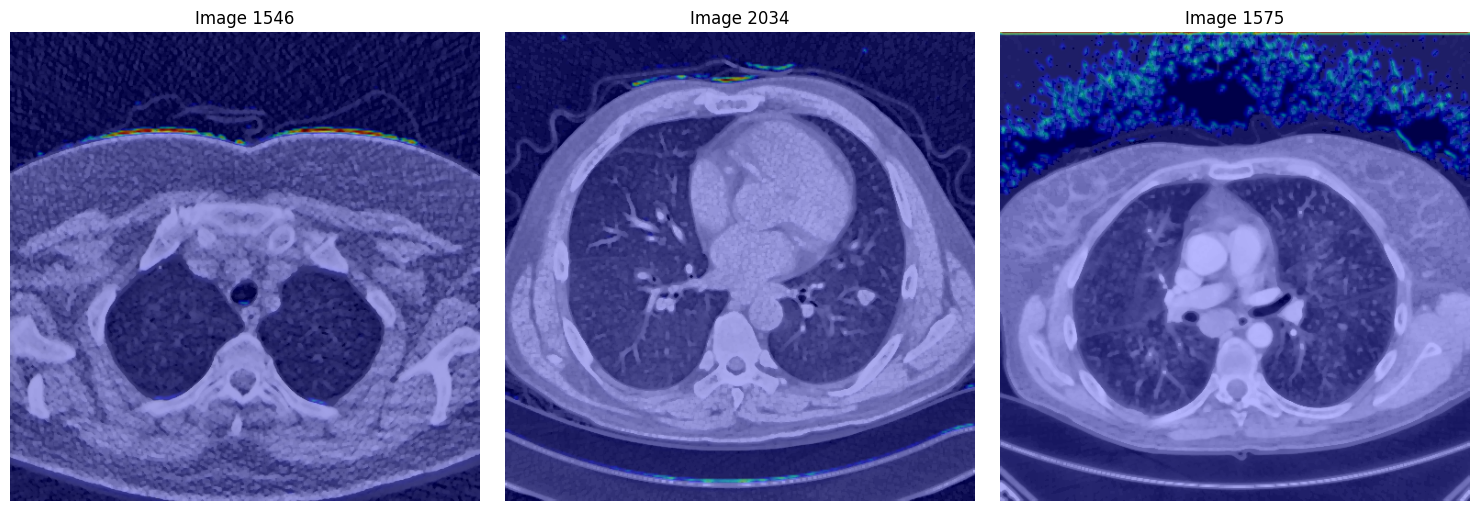

In [18]:
import random

# Sample 3 random indices from X
random_indices = [1546, 2034, 1575]

# Remove last layer's softmax
grad_model.layers[-1].activation = None

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, idx in enumerate(random_indices):
    test_image = np.expand_dims(X[idx], axis=0)
    
    # Compute heatmap
    heatmap = make_gradcam_heatmap([test_image], grad_model, last_conv_layer_name="spatial_dropout_2")
    img = display_gradcam(X[idx], heatmap=heatmap, cam_path=f"./cam_{idx}.png", alpha=0.8)
    
    # Plot heatmap
    axes[i].imshow(img)
    axes[i].set_title(f"Image {idx}")
    axes[i].set_axis_off()

plt.tight_layout()
plt.show()